### Importing Necessary Libraries

In [1]:
from functools import cmp_to_key
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tslearn.clustering import TimeSeriesKMeans

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

### Defining Necessary Constants

In [2]:
DATA_FOLDER = '/home/faranio/Desktop/EDISS/Courses/1st Year. Period 1/Data Intensive Engineering ' \
              'I/Brain-Neuroactivity/data/'

VIDEOS_FOLDER  = os.path.join(DATA_FOLDER, '02_converted')
TABLES_FOLDER  = os.path.join(DATA_FOLDER, '07_pose_tables')
BORDERS_FOLDER = os.path.join(DATA_FOLDER, '10_borders_tables')
DATASET_FOLDER = os.path.join(DATA_FOLDER, '11_dataset')

MAIN_FEATURES = [
    'Lower_Body_To_Body_Distance_12',
    'Mean_Body_Position_Distance_12',
    'Nose_To_Nose_Distance_12',
    'Nose_To_Body_Distance_12',
    'Nose_To_Back_Distance_12',
    'Nose_To_Tail_End_Distance_12'
]

ARENA_LENGTH = 45 # in cm
PROXIMITY = 7     # in cm

### Reading Pose and Borders Keypoints

In [3]:
VIDEO_FILE_NAME = 'Trial_1_v1_SI_w2_control_2593.mp4'

cap = cv2.VideoCapture(os.path.join(VIDEOS_FOLDER, VIDEO_FILE_NAME))
FPS = cap.get(cv2.CAP_PROP_FPS)
FRAME_COUNT = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
DURATION = FRAME_COUNT/FPS # in seconds
BIN_LENGTH = 60            # in seconds
INTERVAL = int(BIN_LENGTH * FPS)

config = {
    'bin_length'  : BIN_LENGTH,
    'duration'    : DURATION,
    'fps'         : FPS,
    'frame_count' : FRAME_COUNT,
    'interval'    : INTERVAL,
    'units_per_cm': ARENA_LENGTH
}

In [5]:
pose_keypoints_path    = os.path.join(TABLES_FOLDER, f'{VIDEO_FILE_NAME}.predictions.h5')
borders_keypoints_path = os.path.join(BORDERS_FOLDER, f'{VIDEO_FILE_NAME}.predictions.h5')

pose_tables   = h5py.File(pose_keypoints_path, 'r')
border_tables = h5py.File(borders_keypoints_path, 'r')

**Main keys:**

- Instance scores
- Node names
- Point scores
- Tracks

In [6]:
pose_node_names   = [str(x)[2:-1] for x in pose_tables['node_names'][:]]
border_node_names = [str(x)[2:-1] for x in border_tables['node_names'][:]]

print('Pose Node names:\n')

for node in pose_node_names:
    print(f'- {node}')

print('\nBorder Node names:\n')

for node in border_node_names:
    print(f'- {node}')

Pose Node names:

- Nose_1
- Upper_Body_1
- Lower_Body_1
- Back_1
- Tail_Middle_1
- Tail_End_1
- Left_Hand_1
- Right_Hand_1
- Left_Leg_1
- Right_Leg_1
- Nose_2
- Body_2
- Back_2
- Tail_Middle_2
- Tail_End_2

Border Node names:

- Left_Upper_Corner
- Right_Upper_Corner
- Right_Lower_Corner
- Left_Lower_Corner


In [7]:
pose_x, pose_y     = pose_tables['tracks'][0]
border_x, border_y = border_tables['tracks'][0]

pose_x, pose_y     = pose_x.transpose(), pose_y.transpose()
border_x, border_y = border_x.transpose(), border_y.transpose()

pose_x.shape, pose_y.shape, border_x.shape, border_y.shape

((7571, 15), (7571, 15), (7571, 4), (7571, 4))

### Showing Video File

In [8]:
def draw_poses(pose_x, pose_y, frame, idx):
    for i in range(pose_x.shape[1]):
        try:
            frame = cv2.circle(frame, (int(pose_x[idx][i]), int(pose_y[idx][i])), 3, (255, 0, 255), 2)
        except ValueError:
            continue
        
    for i in range(5):
        try:
            frame = cv2.line(frame, (int(pose_x[idx][i]), int(pose_y[idx][i])), (int(pose_x[idx][i+1]), int(pose_y[idx][i+1])), (255, 0, 255), 1)
        except ValueError:
            continue
            
    for i, j in zip([1, 1, 2, 2], [6, 7, 8, 9]):
        try:
            frame = cv2.line(frame, (int(pose_x[idx][i]), int(pose_y[idx][i])), (int(pose_x[idx][j]), int(pose_y[idx][j])), (255, 0, 255), 1)
        except ValueError:
            continue
                
    for i in range(10, 14):
        try:
            frame = cv2.line(frame, (int(pose_x[idx][i]), int(pose_y[idx][i])), (int(pose_x[idx][i+1]), int(pose_y[idx][i+1])), (255, 0, 255), 1)
        except ValueError:
            continue

def draw_borders(border_x, border_y, frame, idx):
    for i in range(border_x.shape[1]):
        try:
            frame = cv2.circle(frame, (int(border_x[idx][i]), int(border_y[idx][i])), 3, (255, 0, 255), 2)
        except ValueError:
            continue
        
    for i in range(4):
        if i == 3:
            next_i = 0
        else:
            next_i = i + 1
        
        try:
            frame = cv2.line(frame, (int(border_x[idx][i]), int(border_y[idx][i])), (int(border_x[idx][next_i]), int(border_y[idx][next_i])), (255, 0, 255), 1)
        except ValueError as e:
            continue

In [32]:
cap = cv2.VideoCapture(os.path.join(VIDEOS_FOLDER, VIDEO_FILE_NAME))
idx = 0

while cap.isOpened():      
    ret, frame = cap.read()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    draw_poses(pose_x, pose_y, gray, idx)
    draw_borders(border_x, border_y, gray, idx)
            
    cv2.imshow('frame', gray)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    idx += 1

cap.release()
cv2.destroyAllWindows()

### Feature Engineering

In [10]:
def derive_df(video_file_name):
    pose_keypoints_path = os.path.join(TABLES_FOLDER, f'{video_file_name}.predictions.h5')
    pose_tables = h5py.File(pose_keypoints_path, 'r')
    pose_node_names = [str(x)[2:-1] for x in pose_tables['node_names'][:]]
    pose_x, pose_y = pose_tables['tracks'][0]
    pose_x, pose_y = pose_x.transpose(), pose_y.transpose()
    
    columns = []
    
    for node_name in pose_node_names:
        columns.append(f'{node_name}_x')
        columns.append(f'{node_name}_y')
    
    df = pd.DataFrame(pose_x, columns=[i + '_x' for i in pose_node_names]).join(
        pd.DataFrame(pose_y, columns=[i + '_y' for i in pose_node_names])
    )
    
    df = df[columns]
    return df

def add_auxiliary_features(df, config):
    df['Mean_Body_Position_1_x'] = df[['Nose_1_x', 'Upper_Body_1_x', 'Lower_Body_1_x', 'Back_1_x']].mean(axis=1)
    df['Mean_Body_Position_1_y'] = df[['Nose_1_y', 'Upper_Body_1_y', 'Lower_Body_1_y', 'Back_1_y']].mean(axis=1)
    
    df['Mean_Body_Position_2_x'] = df[['Nose_2_x', 'Body_2_x', 'Back_2_x']].mean(axis=1)
    df['Mean_Body_Position_2_y'] = df[['Nose_2_y', 'Body_2_y', 'Back_2_y']].mean(axis=1)
    
    df['Mean_Body_Position_Distance_12'] = np.linalg.norm(
        df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - df[
            ['Mean_Body_Position_2_x', 'Mean_Body_Position_2_y']].values, axis=1)
    
    df['Close_Proximity'] = (df['Mean_Body_Position_Distance_12'] / config['units_per_cm']) <= PROXIMITY
    df['Close_Proximity'] = df['Close_Proximity'].astype(int)
    
    return df

In [11]:
df = derive_df(VIDEO_FILE_NAME)
df = add_auxiliary_features(df, config)

In [12]:
def total_distance(pos1, pos2, units_per_cm):
    distances = np.linalg.norm(pos2.values - pos1.values, axis=1)
    distances = distances[~np.isnan(distances)]
    distance_in_cm = sum(distances) / units_per_cm
    return distance_in_cm


def total_time_of_interaction(col, duration, frame_count):
    total_time = duration * col.sum() / frame_count
    return total_time


def frequency_of_interaction(interaction_time, length):
    frequency = interaction_time / length
    return frequency


def latency_to_first_interaction(col, duration, frame_count):
    frames = 0
    
    for idx, val in col.items():
        if val == 0:
            frames += 1
        else:
            break
    
    latency = frames / frame_count * duration
    
    return latency


def time_stamped_interaction(col, duration, frame_count):
    time_series = []
    
    for k, v in col.items():
        if v != 0:
            val = v * k / frame_count * duration
            val = round(val, 2)
            time_series.append(val)
    
    return time_series

In [13]:
def derive_features(df, config):
    time_of_interaction = total_time_of_interaction(
        df['Close_Proximity'],
        config['duration'],
        config['frame_count']
    )
    first_interaction_latency = latency_to_first_interaction(
        df['Close_Proximity'],
        config['duration'],
        config['frame_count']
    )
    time_stamped_active_interaction = time_stamped_interaction(
        df['Close_Proximity'],
        config['duration'],
        config['frame_count']
    )
    interaction_frequency = frequency_of_interaction(
        time_of_interaction,
        config['duration']
    )
    distance_traveled = total_distance(
        df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']],
        df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].shift(),
        config['units_per_cm']
    )
    results = {
        'distance_moved': distance_traveled,
        'first_interaction_latency': first_interaction_latency,
        'interaction_frequency': interaction_frequency,
        'time_of_active_interaction': time_of_interaction,
        'time_stamped_active_interaction': time_stamped_active_interaction
    }
    
    return results

def print_feature(feature):
    print("Frequency of interaction (interaction/second): %4.2f" % feature["interaction_frequency"])
    print("Latency to first interaction              (s): %4.2f" % feature["first_interaction_latency"])
    print("Total time of active interaction          (s): %4.2f" % feature["time_of_active_interaction"])
    print("Video duration time                       (s): %4.2f" % DURATION)
    print("Total distance moved by the subject      (cm): %4.2f" % feature["distance_moved"])

In [14]:
features = derive_features(df, config)

In [15]:
print_feature(features)

Frequency of interaction (interaction/second): 0.76
Latency to first interaction              (s): 0.00
Total time of active interaction          (s): 230.44
Video duration time                       (s): 302.84
Total distance moved by the subject      (cm): 804.19


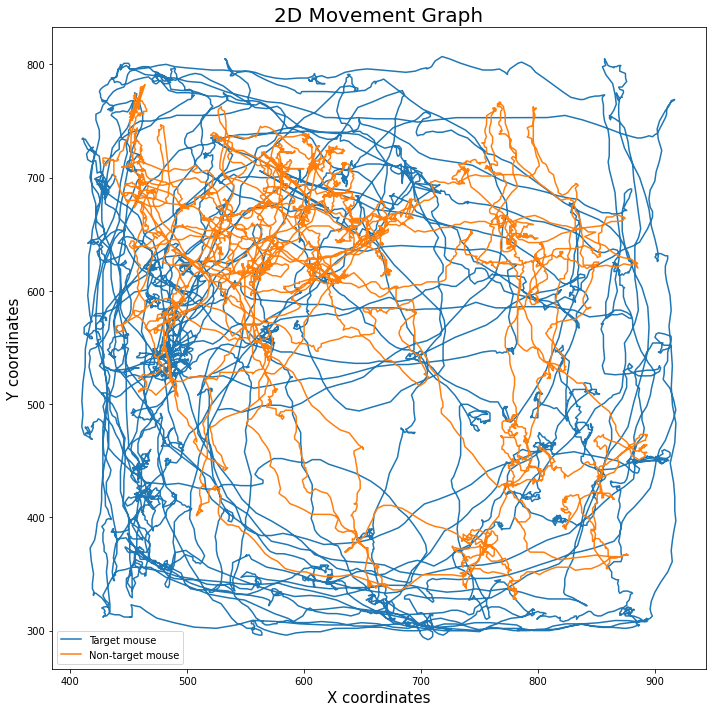

In [16]:
def plot_2d_movement_graph(df, cols):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    idx = 0

    for col in cols:
        ax.plot(df[f'{col}_x'].values, df[f'{col}_y'])
        idx += 1
        
    ax.set_xlabel('X coordinates', fontsize=15)
    ax.set_ylabel('Y coordinates', fontsize=15)
    ax.set_title("2D Movement Graph", fontsize=20)

    plt.legend(["Target mouse", "Non-target mouse"], loc='best')
    plt.tight_layout()
    plt.show();
    
plot_2d_movement_graph(df, ['Mean_Body_Position_1', 'Mean_Body_Position_2'])

### Clustering

In [17]:
def video_name_sort(a, b):
    regex = r'\d+'
    a_nums, b_nums = re.findall(regex, a['Video']), re.findall(regex, b['Video'])
    
    for i, j in zip(a_nums, b_nums):
        if int(i) > int(j):
            return 1
        if int(i) < int(j):
            return -1
    
    return 0

def read_dataset(interpolation=False):
    file_path = os.path.join(DATASET_FOLDER, 'new_dataset.pickle')
    
    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            dataset = pickle.load(file)
    else:
        dataset = []
        min_frame_count = get_minimum_frame_count()
        
        for video_file_name in os.listdir(CONVERTED_DATA_FOLDER):
            config = get_video_config(video_file_name)
            df = derive_df(video_file_name)
            df = add_auxiliary_features(df, config)
            
            if interpolation:
                df = df.interpolate()
            
            df = df.iloc[:min_frame_count, :]
            
            features = derive_features(df, config)
            
            record = {
                'Video': video_file_name,
                'Config': config,
                'Data': df,
                'Features': features
            }
            
            dataset += [record]
        
        with open(file_path, 'wb') as file:
            pickle.dump(dataset, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    dataset = sorted(dataset, key=cmp_to_key(video_name_sort))
    
    first_experiment_dataset  = []
    second_experiment_dataset = []
    
    for i in range(len(dataset)):
        if '_v3_' in dataset[i]['Video']:
            second_experiment_dataset += [dataset[i]]
        else:
            first_experiment_dataset += [dataset[i]]
    
    return first_experiment_dataset, second_experiment_dataset

In [18]:
def get_features_for_clustering(dataset):
    X = []
    columns = list(dataset[0]['Features'].keys())[:4]
    columns.extend(['has_treatment', 'is_week_6'])

    for i in range(len(dataset)):
        values = list(dataset[i]['Features'].values())
        del values[4]  # Deleting time stamped active interaction

        if '_treatment_' in dataset[i]['Video']:
            values.append(1)
        else:
            values.append(0)

        if '_w6_' in dataset[i]['Video']:
            values.append(1)
        else:
            values.append(0)

        X.append(values)

    X = np.array(X)
    X = pd.DataFrame(X, columns=columns)
    X = X.drop(columns='interaction_frequency')
    X[['has_treatment', 'is_week_6']] = X[['has_treatment', 'is_week_6']].astype(np.uint8)

    return X


def show_predictions(df, y_pred, n_clusters, experiment_no):
    for i in range(n_clusters):
        print(df[y_pred == i].describe())

    color_palette = sns.color_palette("husl", n_clusters).as_hex()

    temp_X = df.copy().drop(columns=["has_treatment", "is_week_6"])
    temp_X['y_pred'] = y_pred

    g = sns.pairplot(temp_X, hue='y_pred', palette=color_palette)
    g.fig.suptitle(f"Resultant clusters (Experiment #{experiment_no})", fontsize=20)
    plt.show()

In [19]:
first_dataset, second_dataset = read_dataset()

In [20]:
dataset = first_dataset
n_clusters = 3

In [21]:
X = get_features_for_clustering(dataset)

train_X = X[[
    'distance_moved',
    'first_interaction_latency',
    'time_of_active_interaction'
]]

scaler = StandardScaler()
train_X_transformed = scaler.fit_transform(train_X)
train_X = pd.DataFrame(train_X_transformed, columns=train_X.columns)

clusterer = TimeSeriesKMeans(
    metric='euclidean',
    n_clusters=n_clusters,
    n_jobs=-1,
    random_state=0
)

clusterer.fit(train_X)

y_pred = clusterer.labels_

In [22]:
print(f"Shape of df: {X.shape}")
print(f"Columns of df: {list(X.columns)}")
print(f"Description of df: ")
print(X.describe().T[['mean', 'std', 'max', 'min']])

Shape of df: (72, 5)
Columns of df: ['distance_moved', 'first_interaction_latency', 'time_of_active_interaction', 'has_treatment', 'is_week_6']
Description of df: 
                                   mean         std          max         min
distance_moved              1683.452928  567.661690  4679.626623  504.366164
first_interaction_latency     31.652778   57.267448   251.600000    0.000000
time_of_active_interaction    73.676667   42.251716   189.280000    0.440000
has_treatment                  0.486111    0.503315     1.000000    0.000000
is_week_6                      0.458333    0.501757     1.000000    0.000000


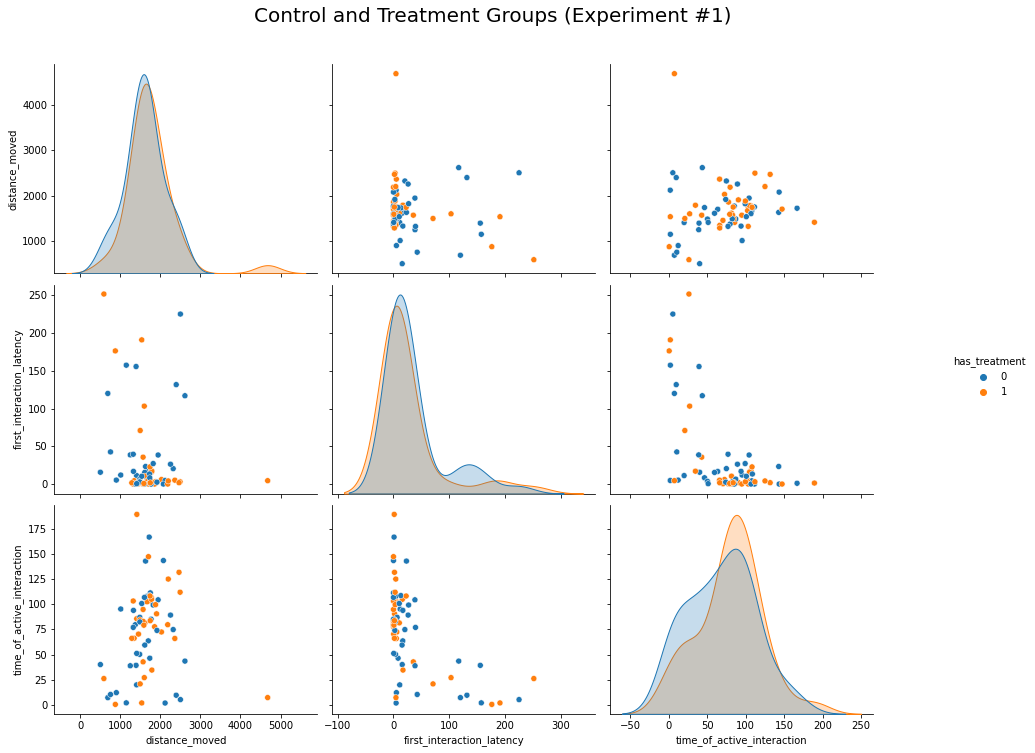

In [23]:
g = sns.pairplot(X.drop(columns="is_week_6"), hue="has_treatment")
g.fig.set_size_inches(15, 10)
g.fig.suptitle("Control and Treatment Groups (Experiment #1)", fontsize=20, y=1.06);

In [24]:
for i in range(n_clusters):
    print(X[y_pred == i].describe().T[['mean', 'std', 'max', 'min']], end='\n\n')

                                   mean         std          max          min
distance_moved              1717.244283  314.067225  2494.112857  1012.432761
first_interaction_latency      8.467407   10.516115    39.480000     0.000000
time_of_active_interaction    92.438519   29.745098   189.280000    34.560000
has_treatment                  0.537037    0.503308     1.000000     0.000000
is_week_6                      0.407407    0.495966     1.000000     0.000000

                                   mean         std          max         min
distance_moved              1399.870172  672.929999  2614.931775  504.366164
first_interaction_latency    106.901176   79.435228   251.600000    4.720000
time_of_active_interaction    17.990588   15.234379    43.480000    0.440000
has_treatment                  0.294118    0.469668     1.000000    0.000000
is_week_6                      0.647059    0.492592     1.000000    0.000000

                                   mean  std          max          m

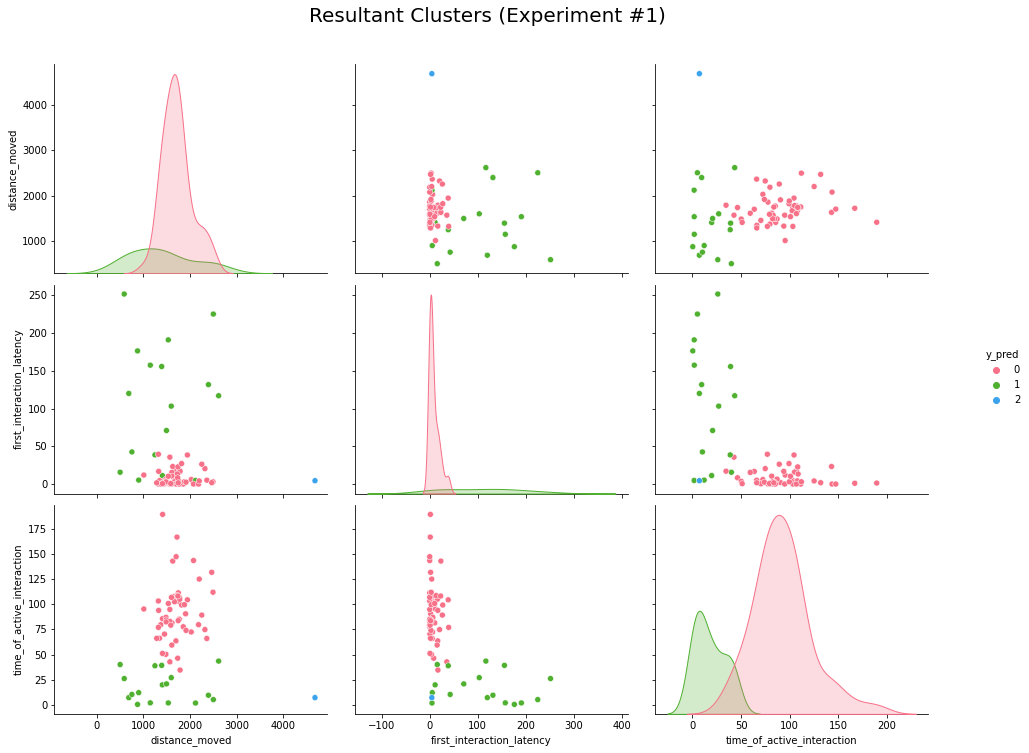

In [25]:
color_palette = sns.color_palette("husl", n_clusters).as_hex()

temp_X = X.copy().drop(columns=["has_treatment", "is_week_6"])
temp_X['y_pred'] = y_pred

g = sns.pairplot(temp_X, hue='y_pred', palette=color_palette)
g.fig.set_size_inches(15, 10)
g.fig.suptitle("Resultant Clusters (Experiment #1)", fontsize=20, y=1.06);

In [26]:
dataset = second_dataset
n_clusters = 2

In [27]:
X = get_features_for_clustering(dataset)

train_X = X[[
    'distance_moved',
    'first_interaction_latency',
    'time_of_active_interaction'
]]

scaler = StandardScaler()
train_X_transformed = scaler.fit_transform(train_X)
train_X = pd.DataFrame(train_X_transformed, columns=train_X.columns)

clusterer = TimeSeriesKMeans(
    metric='euclidean',
    n_clusters=n_clusters,
    n_jobs=-1,
    random_state=0
)

clusterer.fit(train_X)

y_pred = clusterer.labels_

In [28]:
print(f"Shape of df: {X.shape}")
print(f"Columns of df: {list(X.columns)}")
print(f"Description of df: ")
print(X.describe().T[['mean', 'std', 'max', 'min']])

Shape of df: (42, 5)
Columns of df: ['distance_moved', 'first_interaction_latency', 'time_of_active_interaction', 'has_treatment', 'is_week_6']
Description of df: 
                                   mean         std          max         min
distance_moved              1558.864637  613.708790  2843.388292  299.801346
first_interaction_latency     25.120952   52.314005   302.640000    0.000000
time_of_active_interaction    85.699048   41.859700   187.920000    0.000000
has_treatment                  0.500000    0.506061     1.000000    0.000000
is_week_6                      0.476190    0.505487     1.000000    0.000000


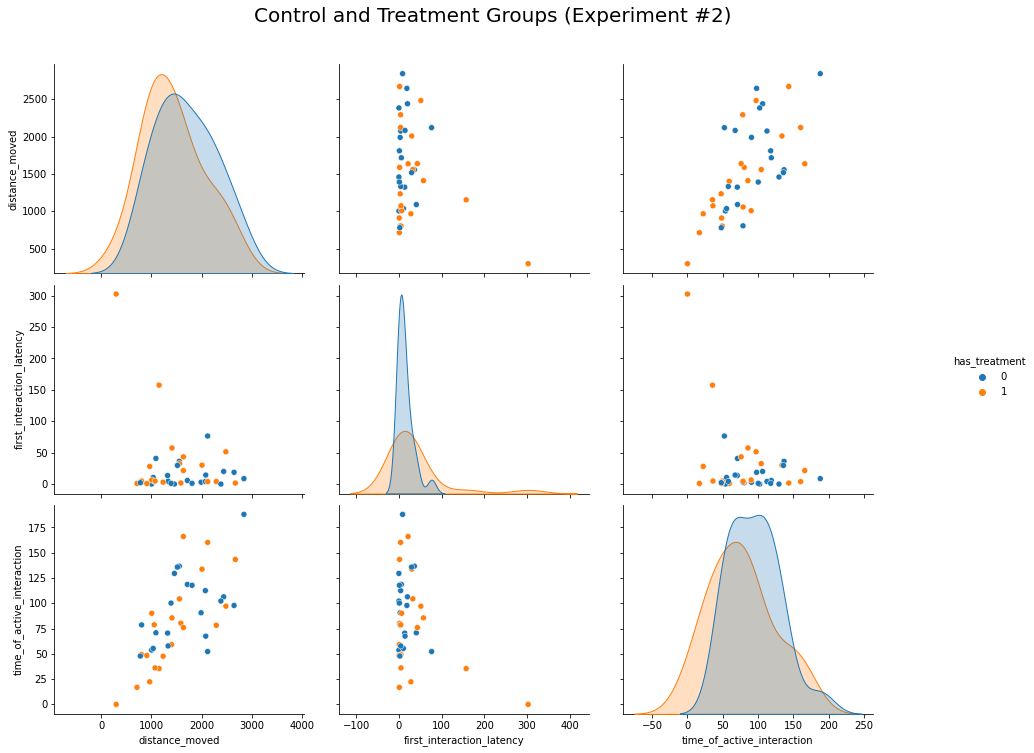

In [29]:
g = sns.pairplot(X.drop(columns="is_week_6"), hue="has_treatment")
g.fig.set_size_inches(15, 10)
g.fig.suptitle("Control and Treatment Groups (Experiment #2)", fontsize=20, y=1.06);

In [30]:
for i in range(n_clusters):
    print(X[y_pred == i].describe().T[['mean', 'std', 'max', 'min']], end='\n\n')

                                   mean         std          max          min
distance_moved              2034.965056  445.790798  2843.388292  1392.238867
first_interaction_latency     14.378000   14.957863    51.400000     0.000000
time_of_active_interaction   119.338000   30.154651   187.920000    67.480000
has_treatment                  0.350000    0.489360     1.000000     0.000000
is_week_6                      0.450000    0.510418     1.000000     0.000000

                                   mean         std          max         min
distance_moved              1126.046075  378.693506  2120.731092  299.801346
first_interaction_latency     34.887273   70.220516   302.640000    0.000000
time_of_active_interaction    55.118182   23.257471    90.120000    0.000000
has_treatment                  0.636364    0.492366     1.000000    0.000000
is_week_6                      0.500000    0.511766     1.000000    0.000000



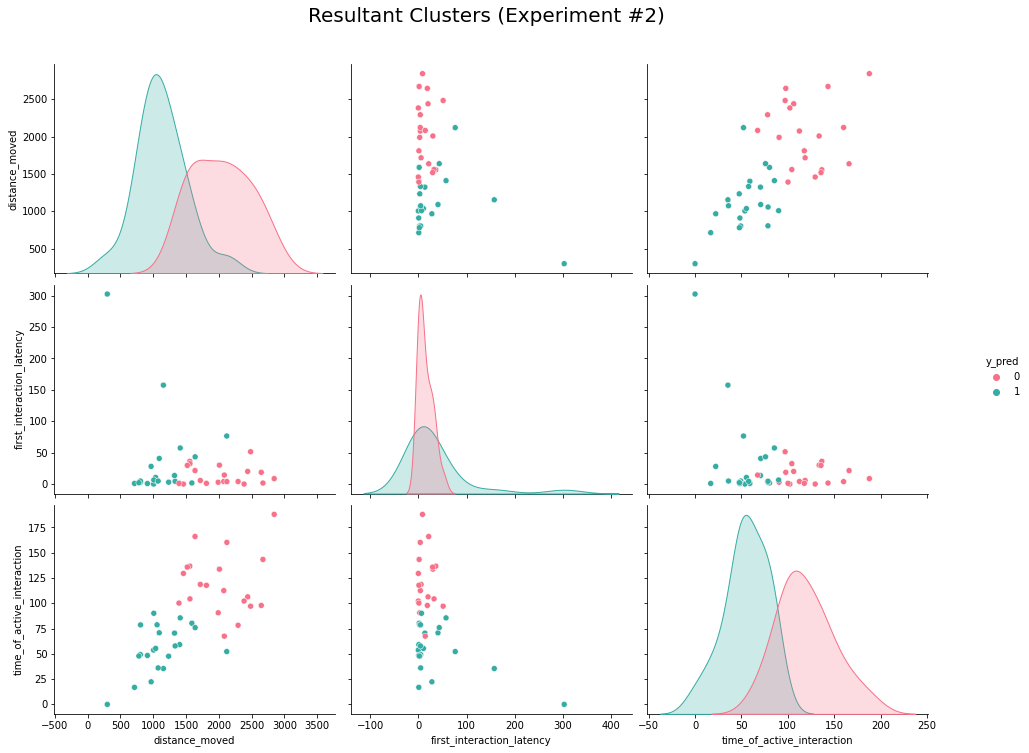

In [31]:
color_palette = sns.color_palette("husl", n_clusters).as_hex()

temp_X = X.copy().drop(columns=["has_treatment", "is_week_6"])
temp_X['y_pred'] = y_pred

g = sns.pairplot(temp_X, hue='y_pred', palette=color_palette)
g.fig.set_size_inches(15, 10)
g.fig.suptitle("Resultant Clusters (Experiment #2)", fontsize=20, y=1.06);